In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
# 68,335,729 data points in total
import random
p = 0.0001  # 0.01% of the lines -> 6800 data points
# keep the header, then take only 1% of lines
# if random from [0,1] interval is greater than 0.01 the row will be skipped
"""
df = pd.read_csv(
         'data/all_events.csv',
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)
"""
df = pd.read_csv('../sorted/AaltoyliopistoMKorkeakouluaukio_sorted.csv')
df.head()

,ts,lat,lon,operative,sid,name,bikes,total_slots
0,2018-05-11T07:48:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",5,40
1,2018-05-11T07:49:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40
2,2018-05-11T07:50:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40
3,2018-05-11T07:51:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40
4,2018-05-11T07:52:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40


## Sort by timestamp

In [3]:
df.sort_values('ts', inplace=True)

## Remove duplicates

In [4]:
df.drop_duplicates(subset=['ts', 'sid'], inplace=True)

## Add some useful columns

In [5]:
from dateutil import tz

# Date and time
df['datetime'] = df.ts.apply(lambda x: pd.to_datetime(x, utc=True).astimezone(tz.tzlocal()))
df['month'] = df.datetime.apply(lambda x: x.month)
df['dayofweek'] = df.datetime.apply(lambda x: x.dayofweek)
df['is_weekend'] = df.dayofweek.apply(lambda x: x >= 5)
df['hour'] = df.datetime.apply(lambda x: x.hour)
df['minutes_from_midnight'] = df.datetime.apply(lambda x: x.hour * 60 + x.minute)

# the percentage of bikes
df['bikes_percent'] = df['bikes'] / df['total_slots']

## Build distribution for weekday and hour

In [6]:
def build_hourly_distribution_by_weekday(rows):
    distribution = []
    prev = None
    count = 0
    for idx, cur in rows:
        if prev is None:
            count += 1
        elif (cur.datetime - prev.datetime).total_seconds() > 120:
            count = 0
        elif prev.bikes >= cur.bikes:
            count += 1
        else:
            distribution.append((cur.dayofweek, cur.hour, count + 1))
            count = 0
        prev = cur
    return distribution
hourly_distribution_by_weekday = build_hourly_distribution_by_weekday(df.iterrows())

In [7]:
labels = ['day_of_week', 'hour', 'wait_time']
df_wait_times = pd.DataFrame.from_records(hourly_distribution_by_weekday, columns=labels)
df_wait_times.head()

,day_of_week,hour,wait_time
0,4,11,17
1,4,11,4
2,4,11,11
3,4,11,12
4,4,11,4


In [137]:
asd = df_wait_times.groupby(by=['day_of_week', 'hour']).wait_time.value_counts(sort=False)

In [180]:
bsd = asd.rename('occurences').reset_index()

In [190]:
bsd = bsd[bsd.occurences > 2]

In [191]:
bsd[bsd.wait_time > 30]

,day_of_week,hour,wait_time,occurences
414,0,21,33,3
1419,3,6,39,3
3223,6,21,34,3


In [193]:
bsd

,day_of_week,hour,wait_time,occurences
16,0,6,3,3
18,0,6,5,4
19,0,6,6,3
22,0,6,9,5
23,0,6,10,3
44,0,7,1,16
45,0,7,2,19
46,0,7,3,12
47,0,7,4,8
48,0,7,5,11


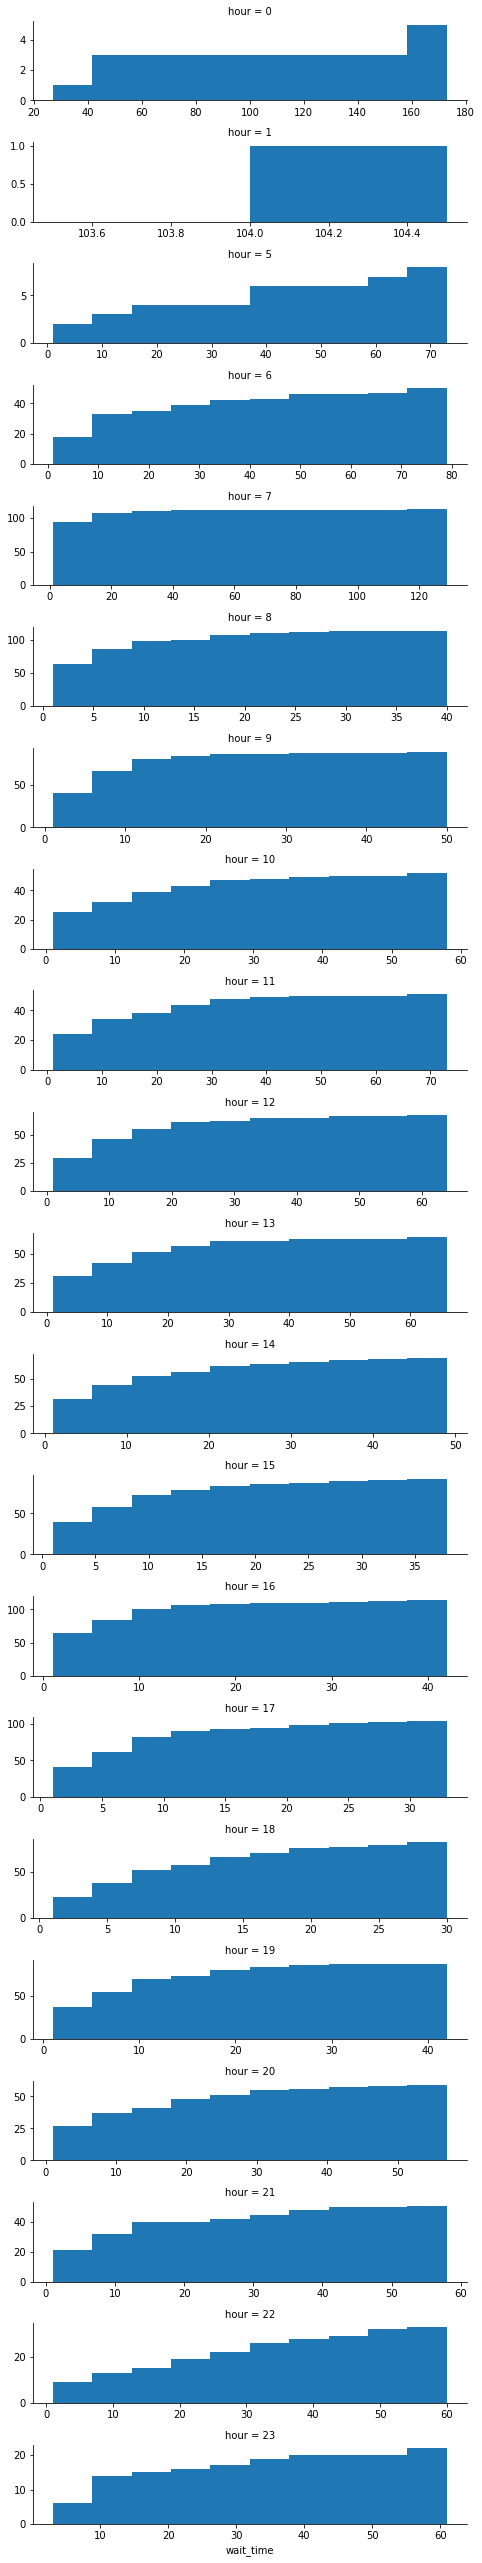

In [10]:
g = sns.FacetGrid(df_wait_times[df_wait_times.day_of_week == 0], row='hour', height=1.7, aspect=4, sharex=False, sharey=False)
g.map(plt.hist, 'wait_time', density=True, cumulative=True)

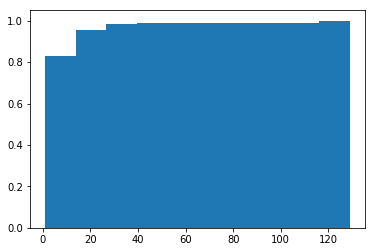

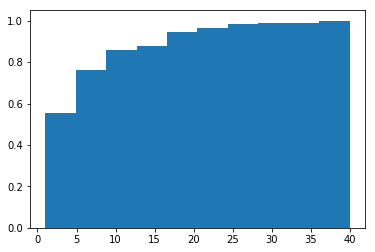

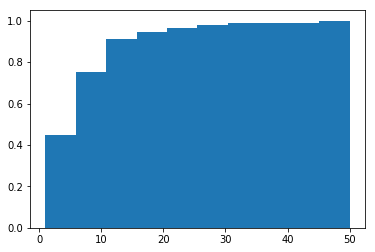

In [47]:
for day_of_week in range(1):
    for hour in range(7,10):
        a, b, c = plt.hist(df_wait_times[(df_wait_times.day_of_week == day_of_week) & (df_wait_times.hour == hour)].wait_time, density=True, cumulative=True)
        plt.show()

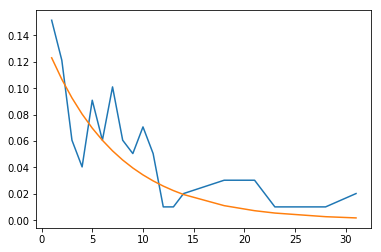

In [118]:
from scipy.optimize import curve_fit
from scipy.stats import expon
import math
asd = df_wait_times[(df_wait_times.day_of_week == 3) & (df_wait_times.hour == 9)].wait_time.value_counts(normalize=True).sort_index()
def expfunc(x, l):
    return l * math.e ** (-l * x)
plt.plot(asd.keys(), asd.values)
popt, pcov = curve_fit(expfunc, asd.keys(), asd.values)
plt.plot(asd.keys(), [expfunc(x, *popt) for x in asd.keys()])

In [122]:
curve_fit(expfunc, asd.keys(), asd.values)

(array([0.14179469]), array([[0.00047772]]))

In [16]:
expon.ppf(0.8, scale=1/0.14179469)

11.350480842647213